# 2. Predicting Soccer Match Winners using ML

In [2]:
import pandas as pd

In [3]:
matches = pd.read_csv('matches.csv')
matches.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,2023-08-13,16:30,Premier League,Matchweek 1,Sun,Away,D,1.0,1.0,Chelsea,...,Match Report,NaN,13.0,1.0,17.8,0.0,0,0,2020,Liverpool
1,2023-08-19,15:00,Premier League,Matchweek 2,Sat,Home,W,3.0,1.0,Bournemouth,...,Match Report,NaN,25.0,9.0,16.8,1.0,0,1,2020,Liverpool
2,2023-08-27,16:30,Premier League,Matchweek 3,Sun,Away,W,2.0,1.0,Newcastle Utd,...,Match Report,NaN,9.0,4.0,17.2,1.0,0,0,2020,Liverpool
3,2023-09-03,14:00,Premier League,Matchweek 4,Sun,Home,W,3.0,0.0,Aston Villa,...,Match Report,NaN,17.0,4.0,14.7,0.0,0,0,2020,Liverpool
4,2023-09-16,12:30,Premier League,Matchweek 5,Sat,Away,W,3.0,1.0,Wolves,...,Match Report,NaN,16.0,5.0,15.8,0.0,0,0,2020,Liverpool


In [4]:
matches.shape

(3456, 27)

### 2.1 Investigating missing data

In [5]:
matches['team'].value_counts()

team
Liverpool                   173
Manchester United           173
Everton                     173
Crystal Palace              173
Wolverhampton Wanderers     173
Chelsea                     173
Newcastle United            173
Brighton and Hove Albion    173
West Ham United             173
Tottenham Hotspur           173
Aston Villa                 173
Arsenal                     173
Manchester City             172
Southampton                 152
Leicester City              152
Burnley                     135
Leeds United                114
Sheffield United             97
Fulham                       97
Brentford                    96
Bournemouth                  96
Watford                      76
Norwich City                 76
Nottingham Forest            59
West Bromwich Albion         38
Luton Town                   20
Name: count, dtype: int64

In [6]:
matches['round'].value_counts()

round
Matchweek 1     100
Matchweek 11    100
Matchweek 21    100
Matchweek 2     100
Matchweek 19    100
Matchweek 16    100
Matchweek 15    100
Matchweek 14    100
Matchweek 13    100
Matchweek 12    100
Matchweek 20    100
Matchweek 10    100
Matchweek 5     100
Matchweek 9     100
Matchweek 4     100
Matchweek 3     100
Matchweek 6     100
Matchweek 7     100
Matchweek 8     100
Matchweek 17     98
Matchweek 18     98
Matchweek 31     80
Matchweek 32     80
Matchweek 37     80
Matchweek 36     80
Matchweek 35     80
Matchweek 28     80
Matchweek 34     80
Matchweek 33     80
Matchweek 25     80
Matchweek 30     80
Matchweek 29     80
Matchweek 27     80
Matchweek 26     80
Matchweek 24     80
Matchweek 23     80
Matchweek 22     80
Matchweek 38     80
Name: count, dtype: int64

### 2.2 Cleaning data for Machine Learning

- Converting 'object' date column to 'datetime'
- Binary encoding 'venue': very important predictor, home advantage, away disadvantage
- Numerically encoding opponents 
- Converting each hour to int, possible that some teams play better at certain times
- Numerically encoding day of week, teams might play better on certain days
- Binary encoding 'result' (Target Variable)

In [8]:
matches['date'] = pd.to_datetime(matches['date'])
matches.dtypes

date            datetime64[ns]
time                    object
comp                    object
round                   object
day                     object
venue                   object
result                  object
gf                     float64
ga                     float64
opponent                object
xg                     float64
xga                    float64
poss                   float64
attendance             float64
captain                 object
formation               object
referee                 object
match report            object
notes                  float64
sh                     float64
sot                    float64
dist                   float64
fk                     float64
pk                       int64
pkatt                    int64
season                   int64
team                    object
dtype: object

Binary Encoding 'venue',  0: Away | 1: Home

In [12]:
matches['venue_code'] = matches['venue'].astype('category').cat.codes

Encoding all Opponents

In [13]:
matches['opp_code'] = matches['opponent'].astype('category').cat.codes

Encoding Hours

In [14]:
matches['hour'] = matches['time'].str.replace(':.+',"",regex=True).astype('int')

Encoding Day of Week

In [16]:
matches['day_code'] = matches['date'].dt.dayofweek

**Encoding Target Variable 'result',  0: Loss, Draw | 1: Win**

In [18]:
matches['target'] = (matches['result'] == 'W').astype('int')

### 2.3 Creating Initial Machine Learning Model
- Random Forest Classifier to predict W/D/L
- Training set: All EPL matches from 2020-01-01 to 2023-12-31
- Test set: All completed EPL matches as of 2024-01-25

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [21]:
# Experiment with different values for min_samples_leaf to decrease overfitting
rf = RandomForestClassifier(n_estimators=50, min_samples_leaf=10, random_state=7)

Test and Training Sets: Since this is time-series data, data in train set must precede test set

In [52]:
# Train data on every match between start of 2020 to end of 2023
train = matches[matches['date'] < '2024-01-01']

In [54]:
# Test data on all 2024 matches
test = matches[matches['date'] >= '2024-01-01']

In [55]:
predictors = ['venue_code', 'opp_code', 'hour', 'day_code']
rf.fit(train[predictors], train['target'])

RandomForestClassifier(min_samples_leaf=10, n_estimators=50, random_state=7)

In [56]:
predictions = rf.predict(test[predictors])

In [57]:
acc = accuracy_score(test['target'], predictions)
acc 

0.75

**Initial Model Accuracy Score: 75%**

In [58]:
combined = pd.DataFrame(dict(actual=test['target'], prediction=predictions))
pd.crosstab(index=combined['actual'], columns=combined['prediction'])

prediction,0,1
actual,,
0,16,2
1,4,2


In [59]:
precision_score(test['target'], predictions)

0.5

**Initial Model Precision Score: 50%**  

### 2.4 Improving Model Precision with Rolling Averages

In [34]:
# Creating dataframe for each club
grouped_matches = matches.groupby('team')

Creating a function for factoring in performance in last three matches to improve model precision

In [35]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values('date')
    rolling_stats = group[cols].rolling(3, closed='left').mean() # closed='left' ensures only previous not current/future data is used
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols) # remove rows with missing values
    return group

Creating new columns for rolling averages

In [38]:
# Goals for, Goals against, Shots taken, Shots on target, Shot distance, Free kicks, Penalty kicks, Penalty kicks attempts
cols = ['gf', 'ga', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']
new_cols = [f"{c}_rolling" for c in cols]

In [37]:
rolling_averages(group, cols, new_cols)

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,day_code,target,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
2965,2019-09-01,16:30,Premier League,Matchweek 4,Sun,Home,D,2.0,2.0,Tottenham,...,6,0,1.333333,1.333333,10.666667,4.666667,17.200000,0.333333,0.000000,0.000000
2966,2019-09-15,16:30,Premier League,Matchweek 5,Sun,Away,D,2.0,2.0,Watford,...,6,0,1.666667,2.000000,16.666667,6.666667,18.600000,1.000000,0.000000,0.000000
2967,2019-09-22,16:30,Premier League,Matchweek 6,Sun,Home,W,3.0,2.0,Aston Villa,...,6,1,1.666667,2.333333,14.000000,5.000000,19.300000,1.000000,0.000000,0.000000
2968,2019-09-30,20:00,Premier League,Matchweek 7,Mon,Away,D,1.0,1.0,Manchester Utd,...,0,0,2.333333,2.000000,17.666667,5.666667,18.600000,1.333333,0.333333,0.333333
2969,2019-10-06,14:00,Premier League,Matchweek 8,Sun,Home,W,1.0,0.0,Bournemouth,...,6,1,2.000000,1.666667,12.333333,4.666667,18.100000,1.000000,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2023-12-17,14:00,Premier League,Matchweek 17,Sun,Home,W,2.0,0.0,Brighton,...,6,1,2.000000,1.666667,18.000000,6.000000,15.300000,0.333333,0.000000,0.000000
58,2023-12-23,17:30,Premier League,Matchweek 18,Sat,Away,D,1.0,1.0,Liverpool,...,5,0,2.000000,1.333333,20.333333,6.666667,14.833333,0.333333,0.000000,0.000000
59,2023-12-28,20:15,Premier League,Matchweek 19,Thu,Home,L,0.0,2.0,West Ham,...,3,0,1.000000,0.666667,17.000000,4.333333,15.400000,0.333333,0.000000,0.000000
60,2023-12-31,14:00,Premier League,Matchweek 20,Sun,Away,L,1.0,2.0,Fulham,...,6,0,1.000000,1.000000,23.000000,6.000000,16.066667,0.000000,0.000000,0.000000


In [49]:
matches_rolling = matches.groupby('team').apply(lambda x: rolling_averages(x, cols, new_cols))

In [50]:
matches_rolling = matches_rolling.droplevel('team') # Dropping redundant team labels to facilitate analysis

In [51]:
matches_rolling.index = range(matches_rolling.shape[0]) # Assigning unique indexes
matches_rolling

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,day_code,target,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
0,2019-09-01,16:30,Premier League,Matchweek 4,Sun,Home,D,2.0,2.0,Tottenham,...,6,0,1.333333,1.333333,10.666667,4.666667,17.200000,0.333333,0.000000,0.000000
1,2019-09-15,16:30,Premier League,Matchweek 5,Sun,Away,D,2.0,2.0,Watford,...,6,0,1.666667,2.000000,16.666667,6.666667,18.600000,1.000000,0.000000,0.000000
2,2019-09-22,16:30,Premier League,Matchweek 6,Sun,Home,W,3.0,2.0,Aston Villa,...,6,1,1.666667,2.333333,14.000000,5.000000,19.300000,1.000000,0.000000,0.000000
3,2019-09-30,20:00,Premier League,Matchweek 7,Mon,Away,D,1.0,1.0,Manchester Utd,...,0,0,2.333333,2.000000,17.666667,5.666667,18.600000,1.333333,0.333333,0.333333
4,2019-10-06,14:00,Premier League,Matchweek 8,Sun,Home,W,1.0,0.0,Bournemouth,...,6,1,2.000000,1.666667,12.333333,4.666667,18.100000,1.000000,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,2023-12-17,14:00,Premier League,Matchweek 17,Sun,Away,L,0.0,3.0,West Ham,...,6,0,1.000000,1.000000,7.666667,3.666667,13.933333,0.333333,0.000000,0.000000
3371,2023-12-24,13:00,Premier League,Matchweek 18,Sun,Home,W,2.0,1.0,Chelsea,...,6,1,0.666667,1.333333,10.333333,3.666667,17.166667,0.333333,0.000000,0.000000
3372,2023-12-27,19:30,Premier League,Matchweek 19,Wed,Away,W,4.0,1.0,Brentford,...,2,1,1.000000,1.666667,12.666667,4.333333,17.466667,0.333333,0.000000,0.000000
3373,2023-12-30,15:00,Premier League,Matchweek 20,Sat,Home,W,3.0,0.0,Everton,...,5,1,2.000000,1.666667,13.000000,4.666667,18.333333,0.333333,0.000000,0.000000


### 2.5 Retraining our Machine Learning Model
- Making a function for retraining model
- Retraining model with rolling averages data as well

In [65]:
def make_predictions(data, predictors):
    train = data[data["date"] < '2024-01-01']
    test = data[data["date"] > '2024-01-01']
    rf.fit(train[predictors], train["target"])
    preds = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)
    precision = precision_score(test["target"], preds)
    acc = accuracy_score(test['target'], preds)
    return combined, precision, acc

In [68]:
combined, precision, acc = make_predictions(matches_rolling, predictors + new_cols)
print(precision, acc)

0.6666666666666666 0.8181818181818182


**New Model Precision Score: 66.66%**

**New Model Accuracy Score: 81.81%**

### 2.6 Combining Home and Away Predictions

In [73]:
combined = combined.merge(matches_rolling[["date", "team", "opponent", "result"]], left_index=True, right_index=True)
combined.head(10) 

,actual,predicted,date_x,team_x,opponent_x,result_x,date_y,team_y,opponent_y,result_y,date,team,opponent,result
169,1,1,2024-01-20,Arsenal,Crystal Palace,W,2024-01-20,Arsenal,Crystal Palace,W,2024-01-20,Arsenal,Crystal Palace,W
339,0,0,2024-01-14,Aston Villa,Everton,D,2024-01-14,Aston Villa,Everton,D,2024-01-14,Aston Villa,Everton,D
432,0,0,2024-01-21,Bournemouth,Liverpool,L,2024-01-21,Bournemouth,Liverpool,L,2024-01-21,Bournemouth,Liverpool,L
525,1,0,2024-01-20,Brentford,Nott'ham Forest,W,2024-01-20,Brentford,Nott'ham Forest,W,2024-01-20,Brentford,Nott'ham Forest,W
694,0,0,2024-01-02,Brighton and Hove Albion,West Ham,D,2024-01-02,Brighton and Hove Albion,West Ham,D,2024-01-02,Brighton and Hove Albion,West Ham,D
695,0,1,2024-01-22,Brighton and Hove Albion,Wolves,D,2024-01-22,Brighton and Hove Albion,Wolves,D,2024-01-22,Brighton and Hove Albion,Wolves,D
827,0,0,2024-01-12,Burnley,Luton Town,D,2024-01-12,Burnley,Luton Town,D,2024-01-12,Burnley,Luton Town,D
997,1,0,2024-01-13,Chelsea,Fulham,W,2024-01-13,Chelsea,Fulham,W,2024-01-13,Chelsea,Fulham,W
1164,0,0,2024-01-20,Crystal Palace,Arsenal,L,2024-01-20,Crystal Palace,Arsenal,L,2024-01-20,Crystal Palace,Arsenal,L
1334,0,0,2024-01-14,Everton,Aston Villa,D,2024-01-14,Everton,Aston Villa,D,2024-01-14,Everton,Aston Villa,D


In [71]:
class MissingDict(dict):
    __missing__ = lambda self, key: key


map_values = {
    "Brighton and Hove Albion": "Brighton", 
    "Manchester United": "Manchester Utd", 
    "Newcastle United": "Newcastle Utd", 
    "Tottenham Hotspur": "Tottenham", 
    "West Ham United": "West Ham", 
    "Wolverhampton Wanderers": "Wolves"
}

mapping = MissingDict(**map_values)

In [74]:
combined["new_team"] = combined["team"].map(mapping)
merged = combined.merge(combined, left_on=["date", "new_team"], right_on=["date", "opponent"])
merged

,actual_x,predicted_x,date_x_x,team_x_x,opponent_x_x,result_x_x,date_y_x,team_y_x,opponent_y_x,result_y_x,...,opponent_x_y,result_x_y,date_y_y,team_y_y,opponent_y_y,result_y_y,team_y,opponent_y,result_y,new_team_y
0,1,1,2024-01-20,Arsenal,Crystal Palace,W,2024-01-20,Arsenal,Crystal Palace,W,...,Arsenal,L,2024-01-20,Crystal Palace,Arsenal,L,Crystal Palace,Arsenal,L,Crystal Palace
1,0,0,2024-01-14,Aston Villa,Everton,D,2024-01-14,Aston Villa,Everton,D,...,Aston Villa,D,2024-01-14,Everton,Aston Villa,D,Everton,Aston Villa,D,Everton
2,0,0,2024-01-21,Bournemouth,Liverpool,L,2024-01-21,Bournemouth,Liverpool,L,...,Bournemouth,W,2024-01-21,Liverpool,Bournemouth,W,Liverpool,Bournemouth,W,Liverpool
3,1,0,2024-01-20,Brentford,Nott'ham Forest,W,2024-01-20,Brentford,Nott'ham Forest,W,...,Brentford,L,2024-01-20,Nottingham Forest,Brentford,L,Nottingham Forest,Brentford,L,Nottingham Forest
4,0,0,2024-01-02,Brighton and Hove Albion,West Ham,D,2024-01-02,Brighton and Hove Albion,West Ham,D,...,Brighton,D,2024-01-02,West Ham United,Brighton,D,West Ham United,Brighton,D,West Ham
5,0,1,2024-01-22,Brighton and Hove Albion,Wolves,D,2024-01-22,Brighton and Hove Albion,Wolves,D,...,Brighton,D,2024-01-22,Wolverhampton Wanderers,Brighton,D,Wolverhampton Wanderers,Brighton,D,Wolves
6,0,0,2024-01-12,Burnley,Luton Town,D,2024-01-12,Burnley,Luton Town,D,...,Burnley,D,2024-01-12,Luton Town,Burnley,D,Luton Town,Burnley,D,Luton Town
7,1,0,2024-01-13,Chelsea,Fulham,W,2024-01-13,Chelsea,Fulham,W,...,Chelsea,L,2024-01-13,Fulham,Chelsea,L,Fulham,Chelsea,L,Fulham
8,0,0,2024-01-20,Crystal Palace,Arsenal,L,2024-01-20,Crystal Palace,Arsenal,L,...,Crystal Palace,W,2024-01-20,Arsenal,Crystal Palace,W,Arsenal,Crystal Palace,W,Arsenal
9,0,0,2024-01-14,Everton,Aston Villa,D,2024-01-14,Everton,Aston Villa,D,...,Everton,D,2024-01-14,Aston Villa,Everton,D,Aston Villa,Everton,D,Aston Villa


In [75]:
merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] ==0)]["actual_x"].value_counts()

actual_x
1    2
0    1
Name: count, dtype: int64

### 2.7 Visualizing the Results

Feature Importance Plot

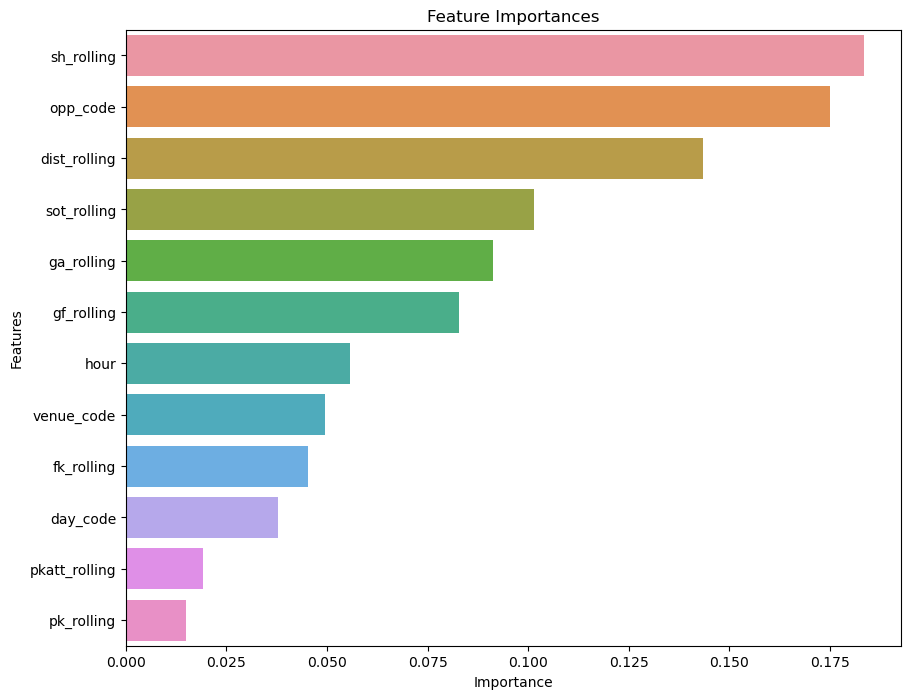

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extracting feature importances
feature_importances = rf.feature_importances_

try:
    feature_names = rf.feature_names_in_
except AttributeError:
    feature_names = train.columns.drop('target') 

# Sorting the features by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Creating the plot
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[sorted_indices], y=feature_names[sorted_indices])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()
